### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [1]:
import HPO

import pysgpp

import matplotlib.pyplot as plt

import tensorflow as tf

import sklearn.metrics

from sklearn.model_selection import KFold

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2

from sklearn.preprocessing import OneHotEncoder, StandardScaler


VERBOSE = 1
CV = 3 #[(slice(None), slice(None))]
TESTING = True

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-05-03 15:43:28.198250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 15:43:29.482197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameter space definition

In [2]:
ITER = 3

hyperparameterspace = {
    'regressor__regressor__epochs': ["interval-int", 1, 20],
    'regressor__regressor__batch_size': ["interval-int", 1, 200],
    'regressor__regressor__model__optimizer__learning_rate': ["interval-log", 0.0000001, 0.1]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste



### Model definition

In [3]:
def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

INITIALIZER = tf.keras.initializers.RandomNormal(stddev=0.05, seed=42)
# 
def create_model(learning_rate=0.0001, input_dim=10):
    # create model
    model = Sequential()
    model.add(Dense(30, input_shape=(input_dim,), activation=ACTIVATION_FUNCTION,
                kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
    model.add(Dense(30, activation=ACTIVATION_FUNCTION,
                kernel_initializer=INITIALIZER, bias_initializer=INITIALIZER))
    model.add(Dense(1, activation=None))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model

### Optimization

In [4]:
ids = [233211]  # , 359952, 359931, 359949, 359938]
# [359940, 317614, 359934, 359946, 359932, 233214, 359943]

valid_datasets = 0
for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(task_id=ids[i])

    print("The average value for target is:", sum(
        dataset.get_Y()/len(dataset.get_Y())))
    print("Min target:", min(dataset.get_Y()),
          "Max target:", max(dataset.get_Y()))

    ################## MODEL AND FUNCTION DEFINITION ####################

    def evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers):

        kfold = KFold(n_splits=CV)

        split = (kfold.split(dataset.get_X(), dataset.get_Y()))

        values = []

        numeric_features = [not x for x in dataset.get_categorical_indicator()]
        numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")),
                   ("scaler", StandardScaler())]
        )

        categorical_transformer = Pipeline(
            steps=[
                ("encoder", OneHotEncoder(
                    handle_unknown="infrequent_if_exist", sparse_output=False)),
                # ("selector", SelectPercentile(chi2, percentile=50)),
            ]
        )

        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer,
                 dataset.get_categorical_indicator()),
            ]
        )

        for i, (train_index, test_index) in enumerate(split):
            X_train = dataset.get_X()[train_index]
            Y_train = dataset.get_Y()[train_index]

            X_val = dataset.get_X()[test_index]
            Y_val = dataset.get_Y()[test_index]

            preprocessor.fit(X_train)

            X_train = preprocessor.transform(X_train)
            X_val = preprocessor.transform(X_val)

            regressor = TransformedTargetRegressor(regressor=KerasRegressor(model=create_model, input_dim=len(X_train[0]), verbose=0),
                                                   transformer=StandardScaler())

            regressor.fit(X_train, Y_train, epochs=epochs,
                          batch_size=batch_size)

            Y_predicted = regressor.predict(X_val)
            error = sklearn.metrics.mean_absolute_error(Y_predicted, Y_val)
            values.append(error)

            K.clear_session()

        result = sum(values)/len(values)
        return result

    def blackboxfunction(params):
        # index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        # hyperparameterspace_special["loss"][index]
        loss = 'mean_squared_error'

        epochs = int(params[0])

        batch_size = int(params[1])

        model_learning_rate = params[2]

        neurons_per_layer = 40  # int(params[3])

        number_of_layers = 1  # int(params[4])

        return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)

    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(
                len(hyperparameterspace.keys()))

        def eval(self, x):
            # index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            # hyperparameterspace_special["loss"][index]
            loss = 'mean_squared_error'

            epochs = int(HPO.from_standard(
                hyperparameterspace_special["regressor__regressor__epochs"][0], hyperparameterspace_special["regressor__regressor__epochs"][1], x[0]))

            batch_size = int(HPO.from_standard(
                hyperparameterspace_special["regressor__regressor__batch_size"][0], hyperparameterspace_special["regressor__regressor__batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["regressor__regressor__model__optimizer__learning_rate"][
                                                        0], hyperparameterspace_special["regressor__regressor__model__optimizer__learning_rate"][1], x[2])

            # int(HPO.from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))
            neurons_per_layer = 40

            # int(HPO.from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))
            number_of_layers = 1

            return evaluate_model(loss, epochs, batch_size, model_learning_rate, neurons_per_layer, number_of_layers)

    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = (j+1) * 3
        print("\n################################################## Current Budget:",
              BUDGET, "##################################################")

        ############################## GRID SEARCH #######################
        print("Performing grid search")

        optimization = HPO.GridSearchOptimization(
            dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        index_best = 0
        for m in range(len(result)):
            if result[m][1] > result[index_best][1]:
                index_best = m

        best_score = result[index_best][1]
        best_params = result[index_best][0]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(
                        best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " +
                          str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        GRID_RESULT.append(best_score)
        GRID_COST.append(cost)

        K.clear_session()

        ########################### RANDOM SEARCH #######################
        print("Performing random search")

        optimization = HPO.RandomSearchOptimization(
            dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        index_best = 0
        for m in range(len(result)):
            if result[m][1] > result[index_best][1]:
                index_best = m

        best_score = result[index_best][1]
        best_params = result[index_best][0]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(
                        best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " +
                          str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        RANDOM_RESULT.append(best_score)
        RANDOM_COST.append(cost)

        K.clear_session()

        ########################### BAYESIAN OPT #####################
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(
            dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)

        result, cost = optimization.fit()

        index_best = 0
        for m in range(len(result)):
            if result[m][1] > result[index_best][1]:
                index_best = m

        best_score = result[index_best][1]
        best_params = result[index_best][0]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(
                        best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " +
                          str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        BAYESIAN_RESULT.append(best_score)
        BAYESIAN_COST.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(
            dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.2, optimizer="rprop")

        result = optimization.fit()

        SPARSE_RESULT.append(result[0][1])
        SPARSE_RESULT_OPTIMIZED.append(result[0][3])

        SPARSE_COST.append(result[1])
        SPARSE_COST_OPTIMIZED.append(result[1])

        K.clear_session()

        print(GRID_RESULT)
        print(RANDOM_RESULT)
        print(BAYESIAN_RESULT)
        print(SPARSE_RESULT)
        print(SPARSE_RESULT_OPTIMIZED)


######################################################################################################################################################
Current Dataset: 1 of 1 with id: 233211
The average value for target is: tensor([3932.8892])
Min target: tensor([326.]) Max target: tensor([18823.])

################################################## Current Budget: 3 ##################################################
Performing grid search


2023-05-03 15:43:33.176905: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


With Hyperparameters: 
regressor__regressor__epochs: 10
regressor__regressor__batch_size: 100
regressor__regressor__model__optimizer__learning_rate: 9.999999999999991e-05
Performing random search
With Hyperparameters: 
regressor__regressor__epochs: 6
regressor__regressor__batch_size: 162
regressor__regressor__model__optimizer__learning_rate: 0.010910687171138718
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 39.31681727800242 seconds
With Hyperparameters: 
regressor__regressor__epochs: 1.0
regressor__regressor__batch_size: 149.0
regressor__regressor__model__optimizer__learning_rate: 6.132441686102442e-05
Performing sparse search
Initial level of sparse grid:  3
Initial level changed!
Adaptive grid generation (Ritter-Novak)...
Done in 19479ms.

Optimal hyperparameters so far:
regressor__regressor__epochs: 10.5
regressor__regressor__batch_size: 100.5
regressor__regressor__model__optimizer__learning_rate: 9.999999999999999e-05
Resulting loss:
844.5524597167969
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (Rprop)...
Done in 0ms.

Optimal hyperparameters after optimization:
regressor__regressor__epochs: 10.5
regressor__regressor__batch_size: 100.5
regressor__regressor__model__optimizer__learning_rate: 9.999999999999999e-05
Resulting loss (Optimal value from optimization):
844.5524597167969
Resulting loss (Optimal point evaluated):
906.5299987792969
[864.13

[1619.0245361328125]
[2342.040974934896]
[1910.8518880208333]
[1469.6566874186199]
[1469.6566874186199]
Current dataset: 0 with name id: 233211


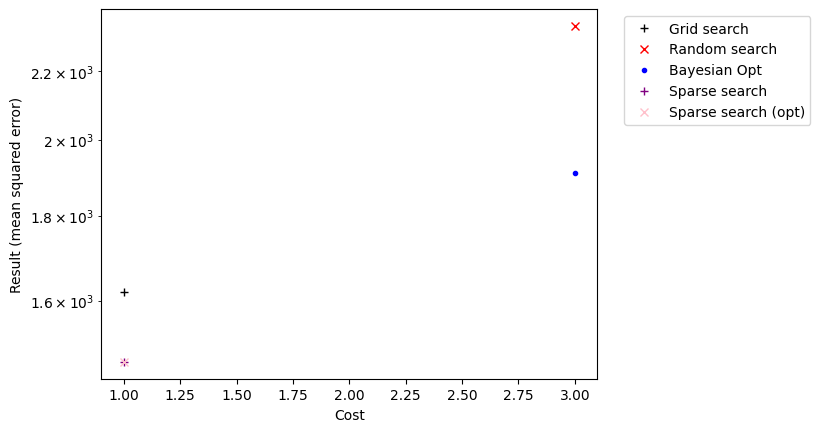

In [ ]:
print(GRID_RESULT)
print(RANDOM_RESULT)
print(BAYESIAN_RESULT)
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)
count = 0
for i in range(len(ids)):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        plt.yscale("log")
        plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

